In [ ]:
import pandas as pd
import numpy as np
import random 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

In [ ]:
patients=pd.read_csv('/content/drive/MyDrive/datasets/patients.csv',header=0)
condition=pd.read_csv('/content/drive/MyDrive/datasets/conditions.csv',header=0)
encounters=pd.read_csv('/content/drive/MyDrive/datasets/encounters.csv',header=0)

In [ ]:
print('The shape of the patients table:',patients.shape)
print('The shape of the condition table:',condition.shape)
print('The shape of the encounters table:',encounters.shape)

The shape of the patients table: (11628, 25)
The shape of the condition table: (256007, 6)
The shape of the encounters table: (1414254, 14)


In [ ]:
print('The name of the patients columns:',patients.columns)
print('The name of the condition columns:',condition.columns)
print('The name of the encounters columns:',encounters.columns)

The name of the patients columns: Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
       'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')
The name of the condition columns: Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')
The name of the encounters columns: Index(['Id', 'START', 'STOP', 'PATIENT', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS',
       'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST',
       'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION'],
      dtype='object')


In [ ]:
#The arguments for timedelta64 are a number, to represent the number of units, and a date/time unit, such as (D)ay, (M)onth, (Y)ear, (h)ours, (m) .
def get_age(x):
  age_deceased=(x['DEATHDATE']- x['BIRTHDATE'])/np.timedelta64(1,'Y')
  age_nondeceased=(pd.datetime.now()- x['BIRTHDATE'])/np.timedelta64(1,'Y')
  age=age_nondeceased if np.isnan(age_deceased) else age_deceased
  return age

patients['BIRTHDATE']=pd.to_datetime(patients['BIRTHDATE'])
patients['DEATHDATE']=pd.to_datetime(patients['BIRTHDATE'])
patients['AGE']=patients.apply(lambda x: get_age(x),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [ ]:
def get_dummy(df,columns,prefix):
  df_dummy=pd.get_dummies(df[columns]) #this function will help us to create a dummy variable with prefix object
  df_dummy.columns=[prefix +'_'+ x for x in df_dummy.columns]
  return df_dummy

In [ ]:
patient_features=patients[['Id','MARITAL', 'RACE', 'ETHNICITY','GENDER','AGE']]
pat_gen=get_dummy(patient_features,'GENDER','pat_gt_GENDER')
pat_race=get_dummy(patient_features,'RACE','pat_gt_RACE')
pat_eth=get_dummy(patient_features,'ETHNICITY','pat_gt_ETHNICITY')
pat_mar=get_dummy(patient_features,'MARITAL','pat_gt_MARITAL')
patient_features=pd.concat([patients[['Id','AGE']],pat_gen,pat_race,pat_eth,pat_mar],axis=1)
patient_features.shape

(11628, 13)

In [ ]:
patient_features.head(n=2)

,Id,AGE,pat_gt_GENDER_F,pat_gt_GENDER_M,pat_gt_RACE_asian,pat_gt_RACE_black,pat_gt_RACE_native,pat_gt_RACE_other,pat_gt_RACE_white,pat_gt_ETHNICITY_hispanic,pat_gt_ETHNICITY_nonhispanic,pat_gt_MARITAL_M,pat_gt_MARITAL_S
0,360a1024-645a-4c50-b94c-1689b34beace,0.0,0,1,0,0,0,0,1,0,1,1,0
1,2d0a9468-9cc7-47c6-a757-2944fb7a754d,0.0,0,1,0,1,0,0,0,0,1,0,0


During EDA process we could see and understand that the patients have there life time records in encounter dataset.That means they usually visit to medical faculty for there health issue.During this process they have Encountered and diagnosed with many health condition which can be retrive from condition dataset


---
**We should use condition dataset to find out the date when the patients was diagnosed with particular condition that will be helpful to find out our target variable.**



In [ ]:
condition[['ENCOUNTER','DESCRIPTION']].groupby('DESCRIPTION').count()\
.sort_values('ENCOUNTER',ascending=False)

,ENCOUNTER
DESCRIPTION,
Viral sinusitis (disorder),53010
Acute viral pharyngitis (disorder),31589
Normal pregnancy,26680
Acute bronchitis (disorder),26230
Otitis media,14697
...,...
Sepsis caused by Pseudomonas (disorder),1
Non-low risk pregnancy,1
Proteinuria due to type 2 diabetes mellitus (disorder),1


In [ ]:
condition['START']=pd.to_datetime(condition['START'])
condition['STOP']=pd.to_datetime(condition['STOP'])  
condition['DURATION']=condition.apply(lambda x: (x['STOP']-x['START'])//np.timedelta64(1,'D'),axis=1)
#The division // of operands where the result is the quotient in which the digits after the decimal point are removed.

In [ ]:
cd=condition[['DESCRIPTION','ENCOUNTER','DURATION']]\
.groupby(['DESCRIPTION'])\
.agg({'ENCOUNTER':'count','DURATION':'mean'})\
.sort_values('ENCOUNTER',ascending=False)
cd[np.isnan(cd['DURATION'])].head()

,ENCOUNTER,DURATION
DESCRIPTION,,
Body mass index 30+ - obesity (finding),4599,NaN
Prediabetes,3556,NaN
Hypertension,3046,NaN
Miscarriage in first trimester,2024,NaN
Hyperlipidemia,1239,NaN


In EDA process we colud see Viral sinusitis and Acute Viral pharyngitis are the most common disorder suffered by patients.

---
The top three condition that stay with the patients for a life time are:-

Body mass index 30+ - obesity (finding)
Prediabetes
Hypertension

1.   Body mass index 30+ - obesity (finding)
2.   Prediabetes
3.   Hypertension

---
These diseases are also called chronic disases,hence its stays life long and this three can be used to build a predictive models for generating health come.

**Obesity**-The ideal way to treat obesity is with a combination of diet, physical activity, and lifestyle changes. Your doctor may also recommend prescription medication or surgery. Managing obesity is about improving your overall health, not just about losing weight. The key to effective weight loss is consistency.

---
**Prediabetes**-These can be controlled with medicine but cant be totally cured.

---
**Hypertension**-Similarly these can be controlled with medicine but cant be totally cured.

**Patient:As we can see obesity can be cured with time rather prediabetes & Hypertension.So we will build our target variable with the help of prediabetes &Hypertension.**

---
# *Let us consider prediabetes:If they are prediabetes we will take the entire timeline before the encounter where they were prediabetes*


*   The target is 1(i.e. these people would be diagnosed as prediabetes)
*   The target is 0(i.e. these people would not be diagnosed as prediabetes)




In [ ]:
target_set=condition[condition['DESCRIPTION']=='Prediabetes'][['PATIENT','ENCOUNTER','START']]

In [ ]:
outside_target=condition[~condition['PATIENT'].isin(target_set['PATIENT'])][['PATIENT','ENCOUNTER']].groupby('PATIENT').count().reset_index()

In [ ]:
encounters['START_DATE']=pd.to_datetime(encounters.apply(lambda x: x['START'][:10],axis=1))
#2000-09-28 09:26:00+00:00 extracting first 10 which will give us idea about YYYY-MM-DD

check for the set of patients who have condition



In [ ]:
encounters_condition=pd.merge(encounters,target_set,on='PATIENT')

In [ ]:
encounters_condition['before']=encounters_condition.apply(lambda x: x['START_y']>x['START_DATE'],axis=1)
##that will give output in form of boolean

Before column is created to identify the encounters that has happended before the condition was diagnosed.

In [ ]:
patient_encounter_before_condition=encounters_condition[encounters_condition['before']]

In [ ]:
patient_encounter_before_condition_encounterclass=patient_encounter_before_condition[['PATIENT','ENCOUNTERCLASS','Id']]\
.groupby(['PATIENT','ENCOUNTERCLASS']).count().reset_index()

Check for the set of patient who do not have condition

In [ ]:
patient_noencounter_condition=encounters[encounters['PATIENT'].isin(outside_target['PATIENT'])]\
.groupby(['PATIENT']).head(50) ##This can be changed later on 

In [ ]:
patient_noencounter_condition_encounterclass=patient_noencounter_condition[['PATIENT','ENCOUNTERCLASS','Id']]\
.groupby(['PATIENT','ENCOUNTERCLASS']).count().reset_index()

We can use pivot table on encounterclass to make features for the field

For patients with condition

In [ ]:
patient_feature_encounterclass=pd.pivot_table(patient_encounter_before_condition_encounterclass,values='Id',
                                              columns=['ENCOUNTERCLASS'],index=['PATIENT'],aggfunc=np.sum)
patient_feature_encounterclass=patient_feature_encounterclass.fillna(0)

In [ ]:
patient_feature_encounterclass.head(n=2)

ENCOUNTERCLASS,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness
PATIENT,,,,,,
0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,11.0,2.0,0.0,6.0,1.0,33.0
0007fa20-c7b2-4764-b4f1-c3e96b241082,3.0,2.0,0.0,5.0,0.0,27.0


For patients without condition

In [ ]:
patient_nocondition=pd.pivot_table(patient_noencounter_condition_encounterclass,values='Id',index=["PATIENT"],
                                   columns=['ENCOUNTERCLASS'],aggfunc=np.sum)
patient_nocondition=patient_nocondition.fillna(0)

In [ ]:
patient_nocondition.head(n=2)

ENCOUNTERCLASS,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness
PATIENT,,,,,,
00059e58-4f1f-49de-b008-3ec6c2aac7e7,15.0,1.0,0.0,6.0,0.0,28.0
000f6134-cefd-41f8-8bc7-144221c7e07e,11.0,1.0,0.0,5.0,2.0,31.0


Features and target variable for model1-Health outcomes

In [ ]:
patient_feature_encounterclass.reset_index(inplace=True)
patient_nocondition.reset_index(inplace=True)

In [ ]:
patient_condition=pd.merge(patient_feature_encounterclass,patient_features,left_on='PATIENT',right_on='Id',how='inner')

In [ ]:
patient_condition.head(n=2)

,PATIENT,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,Id,AGE,pat_gt_GENDER_F,pat_gt_GENDER_M,pat_gt_RACE_asian,pat_gt_RACE_black,pat_gt_RACE_native,pat_gt_RACE_other,pat_gt_RACE_white,pat_gt_ETHNICITY_hispanic,pat_gt_ETHNICITY_nonhispanic,pat_gt_MARITAL_M,pat_gt_MARITAL_S
0,0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,11.0,2.0,0.0,6.0,1.0,33.0,0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,0.0,0,1,0,0,0,0,1,0,1,0,1
1,0007fa20-c7b2-4764-b4f1-c3e96b241082,3.0,2.0,0.0,5.0,0.0,27.0,0007fa20-c7b2-4764-b4f1-c3e96b241082,0.0,1,0,0,0,0,0,1,0,1,0,0


We will select our target as 1(patient with condition)

In [ ]:
patient_condition=patient_condition[['ambulatory', 'emergency', 'inpatient',
       'outpatient', 'urgentcare', 'wellness','AGE', 'pat_gt_GENDER_F',
       'pat_gt_GENDER_M', 'pat_gt_RACE_asian', 'pat_gt_RACE_black',
       'pat_gt_RACE_native', 'pat_gt_RACE_other', 'pat_gt_RACE_white',
       'pat_gt_ETHNICITY_hispanic', 'pat_gt_ETHNICITY_nonhispanic',
       'pat_gt_MARITAL_M', 'pat_gt_MARITAL_S']]

patient_condition['Target']=1

In [ ]:
patient_no_condition=pd.merge(patient_nocondition,patient_features,left_on='PATIENT',right_on='Id',how='inner')

In [ ]:
patient_no_condition.head(n=2)

,PATIENT,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,Id,AGE,pat_gt_GENDER_F,pat_gt_GENDER_M,pat_gt_RACE_asian,pat_gt_RACE_black,pat_gt_RACE_native,pat_gt_RACE_other,pat_gt_RACE_white,pat_gt_ETHNICITY_hispanic,pat_gt_ETHNICITY_nonhispanic,pat_gt_MARITAL_M,pat_gt_MARITAL_S
0,00059e58-4f1f-49de-b008-3ec6c2aac7e7,15.0,1.0,0.0,6.0,0.0,28.0,00059e58-4f1f-49de-b008-3ec6c2aac7e7,0.0,1,0,0,0,0,0,1,0,1,1,0
1,000f6134-cefd-41f8-8bc7-144221c7e07e,11.0,1.0,0.0,5.0,2.0,31.0,000f6134-cefd-41f8-8bc7-144221c7e07e,0.0,0,1,0,0,0,0,1,0,1,1,0


We will select our target as 0(patient without condition)

In [ ]:
patient_no_condition=patient_no_condition[['ambulatory', 'emergency', 'inpatient',
       'outpatient', 'urgentcare', 'wellness','AGE', 'pat_gt_GENDER_F',
       'pat_gt_GENDER_M', 'pat_gt_RACE_asian', 'pat_gt_RACE_black',
       'pat_gt_RACE_native', 'pat_gt_RACE_other', 'pat_gt_RACE_white',
       'pat_gt_ETHNICITY_hispanic', 'pat_gt_ETHNICITY_nonhispanic',
       'pat_gt_MARITAL_M', 'pat_gt_MARITAL_S']]

patient_no_condition['Target']=0

In [ ]:
final_df=pd.concat([patient_condition,patient_no_condition],axis=0)
final_target=final_df['Target']
final_feature=final_df[[x for x in final_df.columns if x!='Target']]

In [ ]:
final_df.describe()

,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,AGE,pat_gt_GENDER_F,pat_gt_GENDER_M,pat_gt_RACE_asian,pat_gt_RACE_black,pat_gt_RACE_native,pat_gt_RACE_other,pat_gt_RACE_white,pat_gt_ETHNICITY_hispanic,pat_gt_ETHNICITY_nonhispanic,pat_gt_MARITAL_M,pat_gt_MARITAL_S,Target
count,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.0,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000,11436.000000
mean,18.504722,2.666055,0.577999,5.620147,0.733298,29.103270,0.0,0.509182,0.490818,0.068643,0.084470,0.003935,0.001399,0.841553,0.111840,0.888160,0.559986,0.140521,0.310948
std,22.336201,2.380574,3.750778,8.281144,1.267141,8.470722,0.0,0.499938,0.499938,0.252857,0.278104,0.062608,0.037380,0.365176,0.315183,0.315183,0.496410,0.347542,0.462902
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,0.000000,2.000000,0.000000,25.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,12.000000,2.000000,0.000000,4.000000,0.000000,29.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,18.000000,4.000000,0.000000,6.000000,1.000000,33.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,354.000000,23.000000,97.000000,183.000000,23.000000,66.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print('Target:',final_target.shape)
print('Feature:',final_feature.shape)

Target: (11436,)
Feature: (11436, 18)


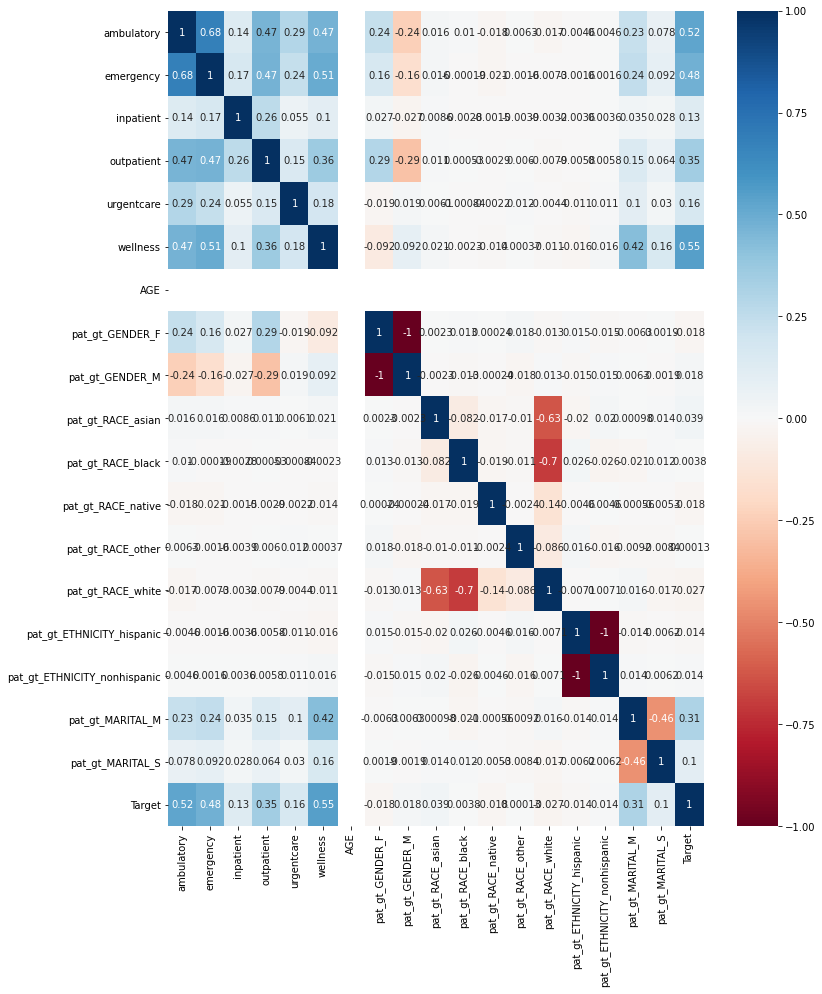

In [ ]:
plt.figure(figsize=(12,15))
corr=final_df.corr()
top_corr_features=corr.index
g=sns.heatmap(final_df[top_corr_features].corr(),annot=True,cmap='RdBu')

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(final_feature,final_target,test_size=0.2,random_state=100)

In [ ]:
print('The shape of X_train:',X_train.shape)
print('The shape of y_train:',y_train.shape)
print('The shape of X_test:',X_test.shape)
print('The shape of y_test:',y_test.shape)

The shape of X_train: (9148, 18)
The shape of y_train: (9148,)
The shape of X_test: (2288, 18)
The shape of y_test: (2288,)


In [ ]:
classifier=RandomForestClassifier()

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


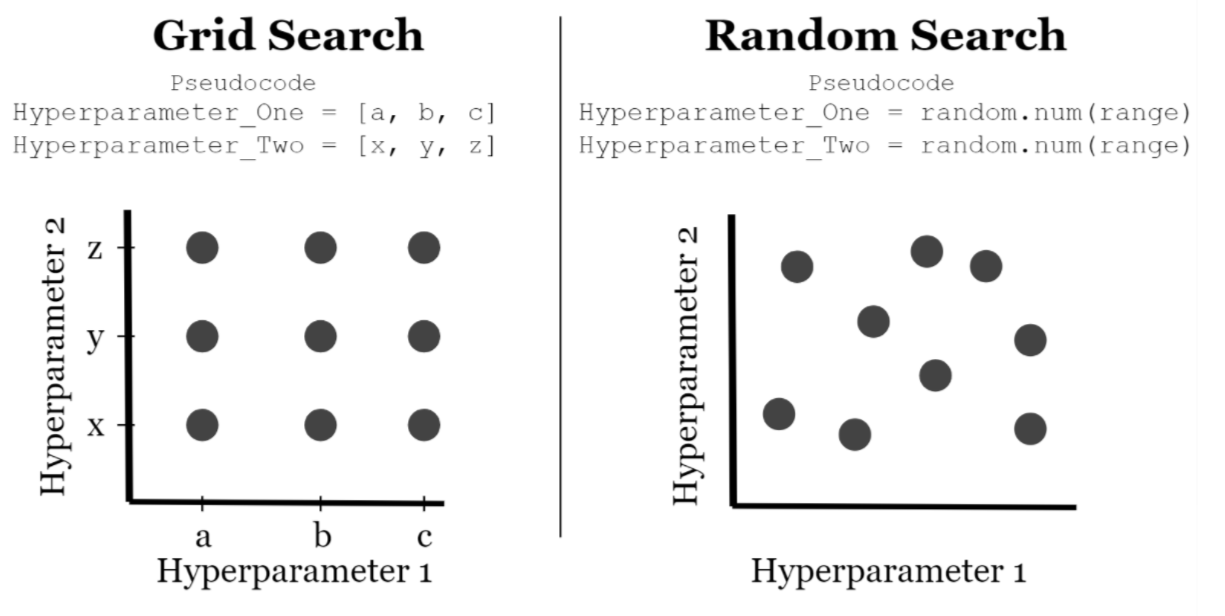

In [ ]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [ ]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=2, random_state=42, n_jobs = 1)   
 ##cv is cross-validation,verbose is to display below code ,n_jobs are use the core of the computer

In [ ]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.9s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   5.3s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
predictions=rf_random.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,predictions)*100
acc

93.31293706293707

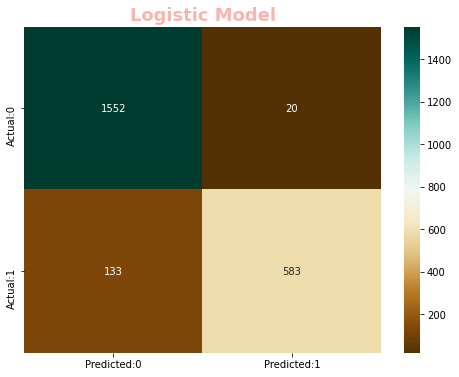

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cf=confusion_matrix(y_test,predictions)
cf_matrix=pd.DataFrame(data=cf,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix,annot=True,fmt='d',cmap='BrBG')
fm={'size':18,'color':'#fbb4ae','weight':'bold'}
plt.title('Logistic Model',**fm)
plt.show()

The confusion matrix shows 1551+584=2135 correct prediction and 132+21=153 incorrect ones

---



1.   True Positive -584
2.   True Negtive-1551
3.   False Positive -21 (Type I error)
4.   False Negtive-132  (Type II error)

---




In [ ]:
TN=cf[0,0]
TP=cf[1,1]
FN=cf[1,0]
FP=cf[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)
print('True Negative:',TN)
print('True Positive:',TP)
print('False Negative:',FN)
print('False Positive:',FP)
print('sensitivity:',sensitivity)
print('specificity:',specificity)

True Negative: 1552
True Positive: 583
False Negative: 133
False Positive: 20
sensitivity: 0.8142458100558659
specificity: 0.9872773536895675


In [ ]:
print('The accuracy of the model= TP+TN/(TP+TN+FP+FN)=',(TP+TN)/float(TP+TN+FP+FN),'\n\n',

'Misclassification =1-Accuracy =',1-((TP+TN)/float(TP+TN+FP+FN)), '\n\n',

'Sensitivity or True positive Rate = TP/(TP+FN)=',TP/float(TP+FN),'\n\n', 
#Sensitivity is a measure of the proportion of actual positive cases that got predicted as positive (or true positive).
'Specificity or True Negative Rate = TN/(TN+FP)=',TN/float(TN+FP),'\n\n',
#Specificity is defined as the proportion of actual negatives, which got predicted as the negative (or true negative). 
'Positive Predictive value = TP/(TP+FP)=',TP/float(TP+FP),'\n\n',

'Negative Predictive value=TN/(TN+FN)=',TN/(TN+FN),'\n\n',

'Positive Likelihood Ratio =Sensitivity/(1-Specificity)=',sensitivity/(1-specificity),'\n\n',

'Negative Likelihood Ratio =(1-Sensitivity)/Specificity=',(1-sensitivity)/specificity)


The accuracy of the model= TP+TN/(TP+TN+FP+FN)= 0.9331293706293706 

 Misclassification =1-Accuracy = 0.06687062937062938 

 Sensitivity or True positive Rate = TP/(TP+FN)= 0.8142458100558659 

 Specificity or True Negative Rate = TN/(TN+FP)= 0.9872773536895675 

 Positive Predictive value = TP/(TP+FP)= 0.966832504145937 

 Negative Predictive value=TN/(TN+FN)= 0.9210682492581602 

 Positive Likelihood Ratio =Sensitivity/(1-Specificity)= 63.999720670391326 

 Negative Likelihood Ratio =(1-Sensitivity)/Specificity= 0.1881479295052698


It's important to recognize that sensitivity and specificity exist in a state of balance. Increased sensitivity – the ability to correctly identify people who have the disease — usually comes at the expense of reduced specificity (meaning more false-positives).

---

The specificity of a test is its ability to designate an individual who does not have a disease as negative.

---
For a test to be useful, sensitivity+specificity should be at least 1.5 (halfway between 1, which is useless, and 2, which is perfect).Whereas we have 1.79 Lets see we can get near 2 or not


---
From the above statistics we can see model is slightly specific than sensitive.The negative value is slightly higher than postive ones.


**Predicted Probabilities of 0(probability of having no condition) and 1 (probability of having condition) for the test data with a default classification threshold 0.5**

In [ ]:
y_pred_prob=rf_random.predict_proba(X_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob,columns=['probability of having no condition(0))','probability of having condition(1)'])
y_pred_prob_df.head()

,probability of having no condition(0)),probability of having condition(1)
0,0.521992,0.478008
1,0.006000,0.994000
2,0.732544,0.267456
3,0.977100,0.022900
4,0.991081,0.008919


predict_proba give us the probability of binary classification of labels (0 & 1)

---
Since the model is predicting too much type II error of probability of having condition,which is not advisable .A False Negative is more dangerous than False Positive in this case.Hence to increase the sensitivity we can lower the threshold.



In [ ]:
from sklearn.preprocessing import binarize
for i in range(1,5):
  cm2=[]
  y_pred_prob_yes=rf_random.predict_proba(X_test)
  y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
  cm2=confusion_matrix(y_test,y_pred2)
  print('With',i/10,'threshold the confusion matrix is','\n',cm2,'\n',
        'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II error(False Negatives)','\n\n',
        'Sensitivity:',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity:',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

With 0.1 threshold the confusion matrix is 
 [[1168  404]
 [  32  684]] 
 with 1852 correct predictions and 32 Type II error(False Negatives) 

 Sensitivity: 0.9553072625698324 Specificity: 0.7430025445292621 



With 0.2 threshold the confusion matrix is 
 [[1385  187]
 [  53  663]] 
 with 2048 correct predictions and 53 Type II error(False Negatives) 

 Sensitivity: 0.9259776536312849 Specificity: 0.8810432569974554 



With 0.3 threshold the confusion matrix is 
 [[1483   89]
 [  75  641]] 
 with 2124 correct predictions and 75 Type II error(False Negatives) 

 Sensitivity: 0.8952513966480447 Specificity: 0.943384223918575 



With 0.4 threshold the confusion matrix is 
 [[1526   46]
 [ 108  608]] 
 with 2134 correct predictions and 108 Type II error(False Negatives) 

 Sensitivity: 0.8491620111731844 Specificity: 0.9707379134860051 





Using [:,1] in the code will give the probabilities of getting the output as 1. Replacing 1 with 0 in the above code, it will only give the probabilities of getting the output as 0.

---
Threshold value 0.1 & 0.2 giving more sensitivity than specificity as we want for our model


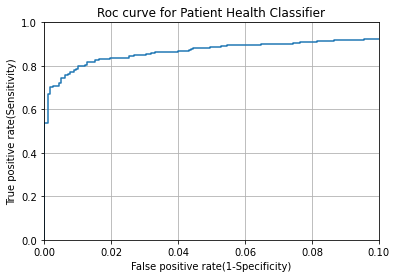

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0,0.1])
plt.ylim([0.0,1.0])
plt.title('Roc curve for Patient Health Classifier')
plt.xlabel('False positive rate(1-Specificity)')
plt.ylabel('True positive rate(Sensitivity)')
plt.grid(True)

In [ ]:
import sklearn
roc_score=sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])
print(round(roc_score,2)*100)

97.0


**Conclusion:**

*   All attributes selected after the elimination process show P-values lower than 5% and thereby suggesting a significant role in the Patient Health Prediction.
*   Men seem to be slightly susceptible than women.Patient suffering mostly by obeseity,hypertension,prediabetes,and it continous life long for most of the encounterclass who are encountered.

*   The model is predicted with 0.93% accuracies.The model is slightly more specific than sensitive.
*   The Area under ROC curve is 97% almost equal to 1,which is satisfactory.


*   We can conclude that the overall model is good.







The higher the area ,the greater is the disparity between true and false positive.An area of 1 is ideal --the closer the AUC to 1,better is the result

**MEDICAL COST PREDICTION**

In [ ]:
encounter_feature_class=encounters.groupby(['PATIENT']).head(50)
##Generating feature for the encounter class feature to get the medical expenses report
encountersclass_feature=encounter_feature_class[['PATIENT','ENCOUNTERCLASS','Id']].groupby(['PATIENT','ENCOUNTERCLASS']).count().reset_index()

In [ ]:
encountersclass_feature=pd.pivot_table(encountersclass_feature,values='Id',index=['PATIENT'],columns=['ENCOUNTERCLASS'],aggfunc=np.sum)\
.reset_index()
encountersclass_feature=encountersclass_feature.fillna(0)

In [ ]:
#merge with patient feature
med_prc=pd.merge(encountersclass_feature,patient_features,left_on='PATIENT',right_on='Id',how='inner')
med_prc.head(n=2)

,PATIENT,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,Id,AGE,pat_gt_GENDER_F,pat_gt_GENDER_M,pat_gt_RACE_asian,pat_gt_RACE_black,pat_gt_RACE_native,pat_gt_RACE_other,pat_gt_RACE_white,pat_gt_ETHNICITY_hispanic,pat_gt_ETHNICITY_nonhispanic,pat_gt_MARITAL_M,pat_gt_MARITAL_S
0,0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,9.0,2.0,0.0,6.0,1.0,32.0,0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,0.0,0,1,0,0,0,0,1,0,1,0,1
1,00059e58-4f1f-49de-b008-3ec6c2aac7e7,15.0,1.0,0.0,6.0,0.0,28.0,00059e58-4f1f-49de-b008-3ec6c2aac7e7,0.0,1,0,0,0,0,0,1,0,1,1,0


In [ ]:
med_prc_target=encounters[~encounters['Id'].isin(encounter_feature_class['Id'])]
med_prc_target.head(n=2)

,Id,START,STOP,PATIENT,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION,START_DATE
255,e2c0e7aa-1f9f-4e92-941d-6e217985443b,2011-01-22T09:26:00Z,2011-01-22T10:41:00Z,2d0a9468-9cc7-47c6-a757-2944fb7a754d,c44f361c-2efb-3050-8f97-0354a12e2920,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,ambulatory,185347001,Encounter for problem,129.16,129.16,59.16,192127007.0,Child attention deficit disorder,2011-01-22
256,1bfc13eb-cfbb-4923-9329-e39c2d2212b0,2011-02-03T09:26:00Z,2011-02-03T09:41:00Z,2d0a9468-9cc7-47c6-a757-2944fb7a754d,c44f361c-2efb-3050-8f97-0354a12e2920,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,ambulatory,185349003,Encounter for 'check-up',129.16,129.16,59.16,263102004.0,Fracture subluxation of wrist,2011-02-03


In [ ]:
med_prc_target=med_prc_target.groupby(['PATIENT'])\
.agg({'BASE_ENCOUNTER_COST':'sum',
      'TOTAL_CLAIM_COST':'sum',
      'PAYER_COVERAGE':'sum'}).reset_index()

In [ ]:
final_price_pred=pd.merge(med_prc,med_prc_target,left_on='PATIENT',right_on='PATIENT',how='inner')

In [ ]:
final_price_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8526 entries, 0 to 8525
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PATIENT                       8526 non-null   object 
 1   ambulatory                    8526 non-null   float64
 2   emergency                     8526 non-null   float64
 3   inpatient                     8526 non-null   float64
 4   outpatient                    8526 non-null   float64
 5   urgentcare                    8526 non-null   float64
 6   wellness                      8526 non-null   float64
 7   Id                            8526 non-null   object 
 8   AGE                           8526 non-null   float64
 9   pat_gt_GENDER_F               8526 non-null   uint8  
 10  pat_gt_GENDER_M               8526 non-null   uint8  
 11  pat_gt_RACE_asian             8526 non-null   uint8  
 12  pat_gt_RACE_black             8526 non-null   uint8  
 13  pat

In [ ]:
numeric_lst=['int16','int32','int64','float16','float32','float64']
numerical_cols=list(final_price_pred.select_dtypes(include=numeric_lst).columns)

In [ ]:
final_price_pred=final_price_pred[numerical_cols]

For regression problem to find out the pricing we are doing feature selection as mutual information

In [ ]:
final_price_pred.head(n=2)

,ambulatory,emergency,inpatient,outpatient,urgentcare,wellness,AGE,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE
0,9.0,2.0,0.0,6.0,1.0,32.0,0.0,12011.88,12011.88,7644.40
1,15.0,1.0,0.0,6.0,0.0,28.0,0.0,9170.36,9170.36,5330.36


In [ ]:
final_price_pred1=final_price_pred[['ambulatory','emergency','inpatient', 'outpatient','urgentcare', 'wellness','AGE', 
        'BASE_ENCOUNTER_COST','PAYER_COVERAGE']]

In [ ]:
target_setm2=final_price_pred['TOTAL_CLAIM_COST']

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

We are doing train and spilt,if we dnt do it ,it might give us overfit model or data linkage if we combine train and test

In classfication we use mutual_info_classif and in regression we use mutual_info_regression.

In [ ]:
from sklearn.feature_selection import mutual_info_regression
#determine the mutual information
mutual_info=mutual_info_regression(final_price_pred1,target_setm2)
mutual_info

array([6.54878920e-02, 0.00000000e+00, 1.17826249e-02, 4.16584798e-03,
       2.01953964e-03, 9.25161833e-02, 0.00000000e+00, 5.67988958e+00,
       1.25238912e+00])

All the values will be greater than 0 and less than 1,higher the value more is the depedent feature is with respect to Total pricing(target variable)

In [ ]:
mutual_info=pd.Series(mutual_info)
mutual_info.index=final_price_pred1.columns
mutual_info.sort_values(ascending=False)

BASE_ENCOUNTER_COST    5.679890
PAYER_COVERAGE         1.252389
wellness               0.092516
ambulatory             0.065488
inpatient              0.011783
outpatient             0.004166
urgentcare             0.002020
AGE                    0.000000
emergency              0.000000
dtype: float64

Estimate mutual information for a continuous target variable.
True mutual information can’t be negative. If its estimate turns out to be negative, it is replaced by zero.

---
Estimate mutual information for a continuous target variable. Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables. If bool, then determines whether to consider all features discrete or continuous.

---
The mutual information between two random variables X and Y can be stated formally as follows: I(X ; Y) = H(X) – H(X | Y)


In [ ]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=40)
selected_top_columns.fit(final_price_pred1,target_setm2)

SelectPercentile(percentile=40,
                 score_func=<function mutual_info_regression at 0x7fa0aa1eecb0>)

In [ ]:
selected_top_columns.get_support()

array([ True, False, False, False, False,  True, False,  True,  True])

In [ ]:
final_price_pred1.columns[selected_top_columns.get_support()]

Index(['ambulatory', 'wellness', 'BASE_ENCOUNTER_COST', 'PAYER_COVERAGE'], dtype='object')

In [ ]:
unimp_columns = [x for x in final_price_pred1
                    if x not in final_price_pred1.columns[selected_top_columns.get_support()]]
print(unimp_columns)

['emergency', 'inpatient', 'outpatient', 'urgentcare', 'AGE']


In [ ]:
for x in unimp_columns:
    final_price_pred1.drop(columns=[x], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X=final_price_pred1
y=target_setm2

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=15)

In [ ]:
print('The shape of X_train:',X_train.shape)
print('The shape of y_train:',y_train.shape)
print('The shape of X_test:',X_test.shape)
print('The shape of y_test:',y_test.shape)

The shape of X_train: (6820, 4)
The shape of y_train: (6820,)
The shape of X_test: (1706, 4)
The shape of y_test: (1706,)


In [ ]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [ ]:
regr=LinearRegression()
regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('The final coefficients after the training is:',regr.coef_)
print('The final intercept after the training is:',regr.intercept_)

The final coefficients after the training is: [ 1.19373046e-12 -1.00044417e-11  2.11884211e+04 -5.40012479e-13]
The final intercept after the training is: 13403.712816715535


The intercept (often labeled as constant) is the point where the function crosses the y-axis. In some analysis, the regression model only becomes significant when we remove the intercept, and the regression line reduces to Y = bX + error or y=mx+c

Understanding the Data 
Final dataset contains 9 features and 6820 training examples.After feature selection we will perform with 4feature. We have to predict the medical expenses for next 6months to 1 year based on available training data.

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
y_pred=regr.predict(X_test)
print('Prediction on test data:',y_pred[:5])    
print('r2_score  of our model is',r2_score(y_test,y_pred))
print('Mean squared error for our model is',mean_squared_error(y_test,y_pred,squared=False))

Prediction on test data: [17524.20325083 17419.42323797 19410.24348232 29259.56469124
  9037.02220911]
r2_score  of our model is 0.9639986799199461
Mean squared error for our model is 4955.727257457534


Regularize the model using Ridge and Lasso Regression and find the score

In [ ]:
from sklearn.linear_model import Ridge,Lasso
ridge=Ridge(alpha=0.005)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
score=r2_score(y_test,ridge_pred)
print('Ridge score:',round(score,2))

Ridge score: 0.96


In [ ]:
lasso=Lasso(alpha=0.005)
lasso.fit(X_train,y_train)
lasso_pred=ridge.predict(X_test)
score=r2_score(y_test,lasso_pred)
print('Lasso score:',round(score,2))

Lasso score: 0.96


**K FOLD**

---

In case of K Fold cross validation input data is divided into 'K' number of folds, hence the name K Fold. Suppose we have divided data into 5 folds i.e. K=5. Now we have 5 sets of data to train and test our model. So the model will get trained and tested 5 times, but for every iteration we will use one fold as test data and rest all as training data. Note that for every iteration, data in training and test fold changes which adds to the effectiveness of this method.

This significantly reduces underfitting as we are using most of the data for training(fitting), and also significantly reduces overfitting as most of the data is also being used in validation set. K Fold cross validation helps to generalize the machine learning model, which results in better predictions on unknown data.

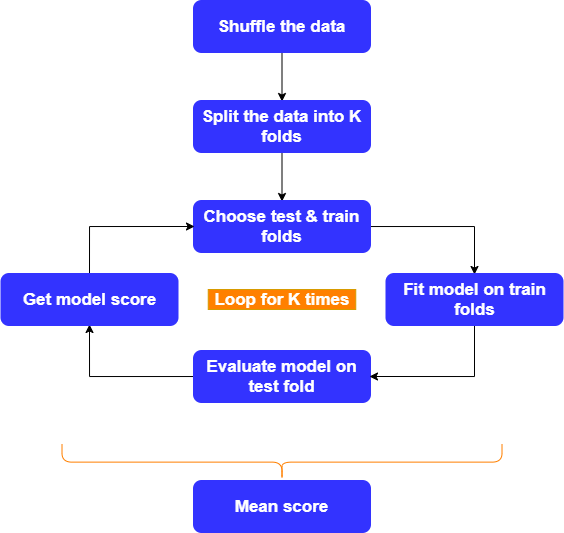

---
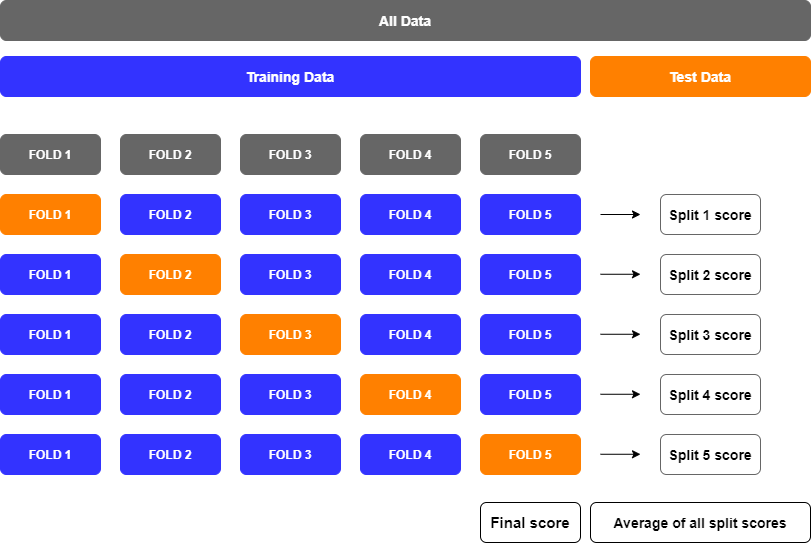


'''Why to calculate RMSE?
ANS: Classification accuracy is reward function, means something you want to maximize. Mean Square Error is loss function, 
means something you want to minimize. Now if we use 'cross_val_score' function then best score(high value) will give worst 
model in case of loss function! There are other sklearn functions which also depends on 'cross_val_score' to select best model by
looking for highest scores, so a design decision was made for 'cross_val_score' to negate the output of all loss function. 
So that when other sklearn function calls 'cross_val_score' those function can always assume that highest score indicate better model.
In short ignore the negative sign and rate the error based on its absolute value."""

Root mean square error is high thus we can reduce it by using cross validation technique for model to perfom more good.

*Model Score Using KFold*

---


Let's use cross_val_score() to evaluate a score by cross-validation. We are going to use two different models for analysis. We will find the score for every split and then take average to get the overall score. We will analyze the model performance based on Root Mean Square Error (RMSE). Since RMSE is not directly available from scoring parameter, first we find the Mean Square Error and then take the square root of it.

In [ ]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 6820, Test set:1706
Fold:2, Train set: 6821, Test set:1705
Fold:3, Train set: 6821, Test set:1705
Fold:4, Train set: 6821, Test set:1705
Fold:5, Train set: 6821, Test set:1705


In [ ]:
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [ ]:
def mse(score_mse):
    mse = np.square(score_mse)
    print(f'mse= {"{:.2f}".format(mse)}')

In [ ]:
score = cross_val_score(DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [  -32567.03972837 -3929732.58945752 -5449793.89008347 -1241432.79910334
  -437792.01195186]
rmse= 1489.38


In [ ]:
score = cross_val_score(RandomForestRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

Scores for each fold are: [  -772517.24250967   -223028.43922209  -4969588.0803285
  -7466844.25476405 -12722391.83672881]
rmse= 2287.11


In [ ]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    rmse(score.mean())

For max depth: 1
rmse= 14781.17
For max depth: 2
rmse= 10757.54
For max depth: 3
rmse= 5429.63
For max depth: 4
rmse= 3125.05
For max depth: 5
rmse= 2974.38
For max depth: 6
rmse= 2735.89
For max depth: 7
rmse= 1564.30
For max depth: 8
rmse= 1520.82
For max depth: 9
rmse= 2298.11
For max depth: 10
rmse= 1783.93


Decision Tree Regressor Tuning 
There are multiple hyperparameters like max_depth, min_samples_split, min_samples_leaf etc which affect the model performance. Here we are going to do tuning based on 'max_depth'. We will try with max depth starting from 1 to 10 and depending on the final 'rmse' score choose the value of max_depth.

In [ ]:
estimators = [50, 100, 150, 200, 250, 300, 350]

for count in estimators:
    score = cross_val_score(RandomForestRegressor(n_estimators= count, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    rmse(score.mean())

For estimators: 50
rmse= 2295.23
For estimators: 100
rmse= 2287.11
For estimators: 150
rmse= 2230.48
For estimators: 200
rmse= 2186.36
For estimators: 250
rmse= 2179.14
For estimators: 300
rmse= 2204.50
For estimators: 350
rmse= 2227.23


Random Forest Regressor Tuning 
There are multiple hyperparameters like n_estimators, max_depth, min_samples_split etc which affect the model performance. Here we are going to do tuning based on 'n_estimators'. We will try with estimators starting from 50 to 350 and depending on the final 'rmse' score choose the value of estimator.

**CONCLUSION:**


*   We could see better accuracy by using feature selection tehcinuqe as mutual information which was giving us 96%.
*   Model was giving high root mean square error which was could be reduced with the cross validation,kFolds algorithm.

*   Model predicted price for medication for coming 6months-1year for the patients,who diagnosed as prediabtes,obesity,hypertension etc.



